In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
# export
from fastai.basic_train import LearnerCallback

In [3]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [4]:
# export
from fastai.core import *

In [5]:
# export
from IPython.core import debugger as idb

In [6]:
#export
from torch.utils.tensorboard import SummaryWriter

In [1]:
# export
from FLAI.detect_symbol.exp import optimizer
#from FLAI.detect_symbol.exp import tensorboard_callback
from FLAI.detect_symbol.exp import scheduling_train

In [2]:
# export
import sys
if '..' not in sys.path:
    sys.path.append('..')
from exp import resnet_unet
from exp import loss_metrics
from exp import databunch
#from exp import train_script_logger

In [3]:
# export
import torch

In [4]:
# export
from torch import tensor

In [5]:
# export
from torch import nn

In [6]:
# export
from torch.nn import Sequential, ModuleList

In [7]:
# export
from fastai.basic_train import Learner

In [8]:
# export
from fastai.torch_core import bn_types,bias_types

In [9]:
# export
from functools import partial

In [10]:
# export
import os,shutil

In [11]:
# export
from fastai.callbacks import CSVLogger

In [12]:
# export
from fastai.callbacks.tracker import SaveModelCallback

In [13]:
import shutil

In [14]:
from fastai.vision import *

In [15]:
import cv2

# functions

In [19]:
# export
def get_learn(data, model_name = 'resnet18', allres = True
              , loss_func_name = 'balance_bce', balance_ratio = 1
              , tag = None):
    assert model_name in ['resnet18', 'assert34'], 'invalid model name'
    assert loss_func_name in ['balance_bce', 'dice_loss', 'combo_loss'], 'invalid loss func name'
    #检查一下确保参数没写错
    assert tag is not None
    if tag is not None:
        #tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200', 'adam'])
        tags = tag.split('__')
        assert model_name == tags[0]
        assert tags[1] in ['allres', 'vanila']
        assert (allres and tags[1] == 'allres') or (not allres and tags[1] == 'vanila')
        if loss_func_name == 'dice_loss':
            assert  len(tags) >= 5
        else:
            assert  len(tags) >= 6
            assert (tags[5] == 'balance_ratio_1' and balance_ratio == 1) \
                    or (tags[5] == 'balance_ratio_10' and balance_ratio == 10) \
                    or (tags[5] == 'balance_ratio_0.1' and balance_ratio == 0.1)
            
    # create model
    model = None
    if model_name == 'resnet18':
        model = resnet_unet.get_unet_res18(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res18_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res18_vanila_init.pth'))
    elif model_name == 'resnet34':
        model = resnet_unet.get_unet_res34(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res34_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res34_vanila_init.pth'))
    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = resnet_unet.split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=[0])
        
    # set loss func
    if loss_func_name == 'combo_loss':
        learn.loss_func = partial(loss_metrics.combo_loss, balance_ratio=balance_ratio)
    elif loss_func_name == 'dice_loss':
        learn.loss_func = loss_metrics.dice_loss
    elif loss_func_name == 'balance_bce':
        learn.loss_func = partial(loss_metrics.balance_bce, balance_ratio=balance_ratio)
    
    # 添加metrics
    learn.metrics += [loss_metrics.dice_loss]
    learn.metrics += [partial(loss_metrics.balance_bce,balance_ratio=1)]
    learn.metrics += [loss_metrics.mask_iou]
    
    return learn

In [22]:
#export
model_names = ['resnet18', 'assert34']
loss_func_names = ['dice_loss', 'balance_bce', 'combo_loss']
balance_ratios = [1, 0.1, 10]
dataset_dirs = ['data/dataset_20200715', 'data/dataset_20200715_2000', 'data/dataset_20200715_200_et']
dataset_names = ['dataset200', 'dataset2000', 'dataset200_et']

In [23]:
#把结果备份一下
def backup_train_logs(tag, dst_root = 'train_logs'):    
    src_dirs = ['run_log', 'tb_log']
    path = os.path.join(dst_root, tag)
    os.makedirs(path, exist_ok = True)
    for d in src_dirs:        
        dst = os.path.join(dst_root, tag, d)
        #3.8的python才有dirs_exist_ok。现在只能先删掉
        shutil.rmtree(dst, ignore_errors = True)
        shutil.copytree(d, dst)
    ds = tag.split('__')[3]
    assert ds in dataset_names, ds + '???'
    csvpath = dataset_dirs[dataset_names.index(ds)] + '/image'
    shutil.rmtree(os.path.join(path, 'csv_log'), ignore_errors = True)
    #print(os.path.join(csvpath, 'csv_log'), path)
    shutil.copytree(os.path.join(csvpath, 'csv_log'), os.path.join(path, 'csv_log'))

# test

In [24]:
# export
# 设置device
device = torch.device('cuda')

In [25]:
BS = 16

In [26]:
optf_adam = partial(optimizer.Adam, betas=(0.9,0.99))

In [68]:
# 200数据集
ds = './data/dataset_20200715'
data_200 = databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [69]:
# 2000数据集
ds = './data/dataset_20200715_2000'
data_2000 = databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [27]:
# 200带elastic_transform数据集
ds = './data/dataset_20200715_200_et'
data_200et = databunch.get_databunch_et(ds, bs=BS, device=device, transforms = None) 

## 数据集比较

### 200数据集，无transform,resnet18，allres,dice,adam

In [63]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200', 'adam'])

In [64]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [74]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


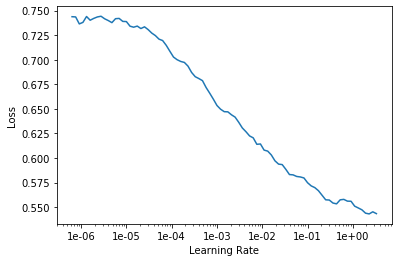

In [64]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [71]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.610610,0.755079,0.755079,0.668652,0.213382,00:22
1,0.559654,0.695043,0.695043,0.564333,0.324456,00:22
2,0.537154,0.603292,0.603292,0.600829,0.324799,00:22
3,0.520687,0.533004,0.533004,0.804303,0.349211,00:22
4,0.501595,0.510433,0.510433,0.967319,0.359203,00:22
5,0.475195,0.396737,0.396737,0.674145,0.466871,00:22
6,0.437727,0.281640,0.281640,0.715841,0.577688,00:22
7,0.399568,0.292850,0.292850,1.086517,0.558671,00:22
8,0.365667,0.230956,0.230956,0.586369,0.655903,00:22
9,0.336315,0.190047,0.190047,0.652293,0.690253,00:22


Better model found at epoch 0 with valid_loss value: 0.755079448223114.
Better model found at epoch 1 with valid_loss value: 0.695042610168457.
Better model found at epoch 2 with valid_loss value: 0.6032920479774475.
Better model found at epoch 3 with valid_loss value: 0.5330035090446472.
Better model found at epoch 4 with valid_loss value: 0.5104333162307739.
Better model found at epoch 5 with valid_loss value: 0.3967370092868805.
Better model found at epoch 6 with valid_loss value: 0.2816401720046997.
Better model found at epoch 8 with valid_loss value: 0.230955570936203.
Better model found at epoch 9 with valid_loss value: 0.19004663825035095.
Better model found at epoch 12 with valid_loss value: 0.16728903353214264.
Better model found at epoch 14 with valid_loss value: 0.1649456024169922.
Better model found at epoch 15 with valid_loss value: 0.1338915377855301.
Better model found at epoch 17 with valid_loss value: 0.13074588775634766.
Better model found at epoch 18 with valid_loss 

In [82]:
backup_train_logs(tag)

In [ ]:
epochs:240,train_loss:0.012935,mask_iou:0.922264

### 2000数据集，无transform,resnet18，allres,dice,adam

In [66]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset2000','adam'])

In [72]:
getlearn = partial(get_learn, data = data_2000, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [73]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


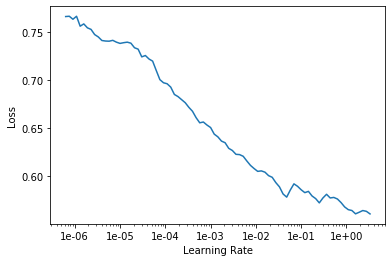

In [83]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [89]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.343741,0.275967,0.275967,0.832594,0.578787,04:02
1,0.190607,0.110784,0.110784,0.578189,0.803420,04:02
2,0.118330,0.097209,0.097209,0.600622,0.824674,04:00
3,0.089307,0.072525,0.072525,0.420103,0.866379,04:00
4,0.075614,0.068155,0.068155,0.291228,0.873257,04:00
5,0.068708,0.084531,0.084531,0.352046,0.845168,04:00
6,0.063752,0.056669,0.056669,0.503608,0.894085,03:59
7,0.056909,0.052714,0.052714,0.460271,0.900575,04:00
8,0.052214,0.048201,0.048201,0.344029,0.908381,04:00
9,0.052278,0.073633,0.073633,0.760601,0.863644,04:00


Better model found at epoch 0 with valid_loss value: 0.27596670389175415.
Better model found at epoch 1 with valid_loss value: 0.11078394204378128.
Better model found at epoch 2 with valid_loss value: 0.09720931947231293.
Better model found at epoch 3 with valid_loss value: 0.07252483069896698.
Better model found at epoch 4 with valid_loss value: 0.06815541535615921.
Better model found at epoch 6 with valid_loss value: 0.05666894093155861.
Better model found at epoch 7 with valid_loss value: 0.05271410942077637.
Better model found at epoch 8 with valid_loss value: 0.048200543969869614.
Better model found at epoch 10 with valid_loss value: 0.043685805052518845.
Better model found at epoch 11 with valid_loss value: 0.03827884420752525.
Better model found at epoch 12 with valid_loss value: 0.036419838666915894.
Better model found at epoch 15 with valid_loss value: 0.031563516706228256.
Better model found at epoch 19 with valid_loss value: 0.030112363398075104.
Better model found at epoch 

Better model found at epoch 221 with valid_loss value: 0.008396374993026257.
Better model found at epoch 223 with valid_loss value: 0.008363435044884682.
Better model found at epoch 226 with valid_loss value: 0.008266935124993324.
on end of epoch#226: start annealing from 0.0001 to 1e-05
Better model found at epoch 227 with valid_loss value: 0.008151202462613583.
Better model found at epoch 228 with valid_loss value: 0.008087804540991783.
Better model found at epoch 234 with valid_loss value: 0.008083577267825603.
Better model found at epoch 236 with valid_loss value: 0.008028528653085232.
Better model found at epoch 238 with valid_loss value: 0.008004915900528431.
Better model found at epoch 241 with valid_loss value: 0.008002088405191898.
Better model found at epoch 245 with valid_loss value: 0.008000807836651802.
Better model found at epoch 250 with valid_loss value: 0.007980945520102978.
Better model found at epoch 253 with valid_loss value: 0.007964667864143848.
on end of epoch#25

In [110]:
backup_train_logs(tag)

In [ ]:
epochs:256,train_loss:0.002,mask_iou:0.984

### 200_et数据集，无transform,resnet18，allres,dice,adam

In [28]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200_et','adam'])

In [29]:
getlearn = partial(get_learn, data = data_200et, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [77]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_200_et/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_200_et/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


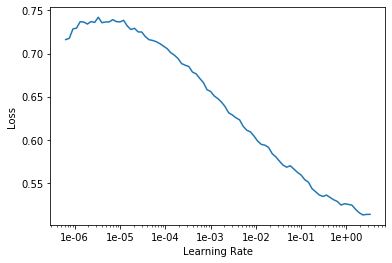

In [55]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [56]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.537512,0.673003,0.673003,0.577600,0.362814,00:43
1,0.496501,0.480625,0.480625,0.695043,0.412130,00:42
2,0.459644,0.328490,0.328490,0.692735,0.556367,00:42
3,0.386793,0.250233,0.250233,0.835298,0.616732,00:42
4,0.322920,0.470282,0.470282,1.543848,0.369673,00:43
5,0.275181,0.311829,0.311829,1.338466,0.529710,00:43
6,0.245175,0.246989,0.246989,1.640386,0.615743,00:42
7,0.213537,0.194699,0.194699,0.543641,0.685413,00:42
8,0.189658,0.174415,0.174415,1.038536,0.712113,00:42
9,0.167762,0.140198,0.140198,0.751412,0.757339,00:42


Better model found at epoch 0 with valid_loss value: 0.6730028986930847.
Better model found at epoch 1 with valid_loss value: 0.4806247651576996.
Better model found at epoch 2 with valid_loss value: 0.3284897804260254.
Better model found at epoch 3 with valid_loss value: 0.2502334713935852.
Better model found at epoch 6 with valid_loss value: 0.24698877334594727.
Better model found at epoch 7 with valid_loss value: 0.19469943642616272.
Better model found at epoch 8 with valid_loss value: 0.17441478371620178.
Better model found at epoch 9 with valid_loss value: 0.1401984989643097.
Better model found at epoch 11 with valid_loss value: 0.11481285095214844.
Better model found at epoch 13 with valid_loss value: 0.0872698649764061.
Better model found at epoch 14 with valid_loss value: 0.08725808560848236.
Better model found at epoch 18 with valid_loss value: 0.07185699045658112.
Better model found at epoch 21 with valid_loss value: 0.06715203821659088.
Better model found at epoch 25 with val

In [57]:
backup_train_logs(tag)

In [ ]:
epochs:113,train_loss:0.023,mask_iou:0.918

In [ ]:
#重新运行一遍，加大平台期判断参数
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True, worseN_th=10)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.546440,0.682547,0.682547,0.599445,0.340727,00:51
1,0.497982,0.473716,0.473716,0.718473,0.424418,00:42
2,0.459273,0.336886,0.336886,0.668305,0.544561,00:42
3,0.409736,0.275400,0.275400,0.967433,0.586668,00:42


Better model found at epoch 0 with valid_loss value: 0.6825472116470337.
Better model found at epoch 1 with valid_loss value: 0.4737156927585602.
Better model found at epoch 2 with valid_loss value: 0.33688583970069885.
Better model found at epoch 3 with valid_loss value: 0.2754003703594208.


In [ ]:
backup_train_logs(tag)

#### 第二次运行加大了平台期判断阈值，结果还是0.92，跑满了500轮

### 阶段结果：
2000数据集效果最好，mask_iou 0.984.在28轮的时候就到了0.955，耗时约112min。143轮到达0.98，耗时约572min。最后在256轮的时候停止。  

200数据集mask_iou 0.922,240轮，耗时约88min。  

200+et(elastic transform)数据集，mask_iou 0.918,113轮，耗时约79min。

其中200+et数据集虽然数量多于200数据集，但是效果并没有更好，不过收敛要略快一些。

### elastic transform的变换效果

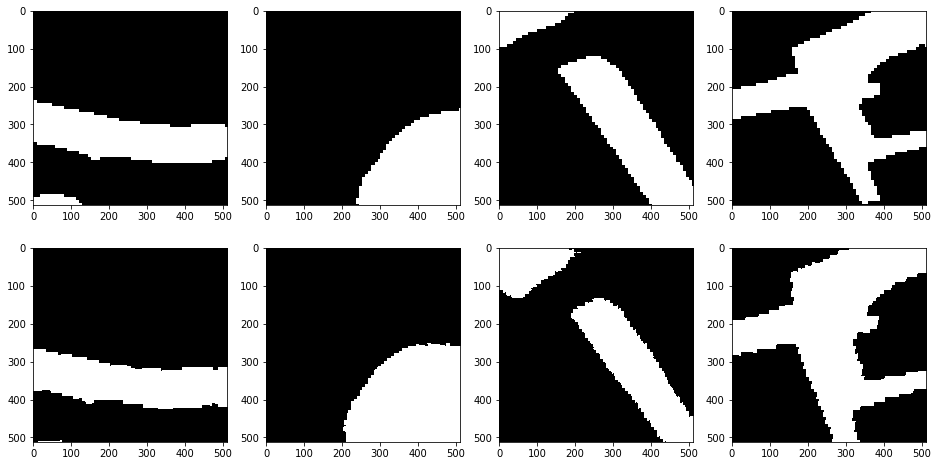

In [296]:
#imgfns = ['00000_et_mask.png',]
rootdir = './data/dataset_20200715_200_et/mask/'
imgfns = ['00004_mask.png', '00008_mask.png', '00002_mask.png', '00006_mask.png']
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(imgfns)):
    #axs[0, i].imshow(PIL.Image.open(rootdir + imgfns[i]))
    axs[0, i].imshow(cv2.imread(rootdir + imgfns[i]) * 255)
for i in range(len(imgfns)):    
    #print(rootdir + imgfns[i].replace('_mask', '_et_mask'))
    #axs[1, i].imshow(PIL.Image.open(rootdir + imgfns[i].replace('_mask', '_et_mask')))
    axs[1, i].imshow(cv2.imread(rootdir + imgfns[i].replace('_mask', '_et_mask')) * 255)

## 比较allres和vanila

### 200数据集，无transform，resnet18，vanila，dice，adam

In [93]:
tag = '__'.join(['resnet18', 'vanila', 'dice_loss', 'dataset200','adam'])

In [94]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [80]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [32]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.576685,0.772869,0.772869,0.801760,0.000000,00:33
1,0.399787,0.819375,0.819375,0.978611,0.000000,00:23
2,0.318971,0.912573,0.912573,1.469705,0.000000,00:23
3,0.281842,0.818690,0.818690,1.331423,0.000515,00:24
4,0.260006,0.183279,0.183279,0.487018,0.712198,00:24
5,0.232149,0.203520,0.203520,0.738799,0.667679,00:23
6,0.205030,0.097140,0.097140,0.332182,0.830428,00:23
7,0.183030,0.253476,0.253476,1.106604,0.602793,00:23
8,0.167124,0.156643,0.156643,0.685680,0.751681,00:23
9,0.152730,0.180903,0.180903,0.601902,0.696833,00:23


Better model found at epoch 0 with valid_loss value: 0.7728694081306458.
Better model found at epoch 4 with valid_loss value: 0.1832788586616516.
Better model found at epoch 6 with valid_loss value: 0.09714015573263168.
Better model found at epoch 12 with valid_loss value: 0.08770924806594849.
Better model found at epoch 15 with valid_loss value: 0.08284346759319305.
Better model found at epoch 16 with valid_loss value: 0.07922443002462387.
Better model found at epoch 18 with valid_loss value: 0.07636988162994385.
Better model found at epoch 20 with valid_loss value: 0.07416640222072601.
Better model found at epoch 23 with valid_loss value: 0.06058864668011665.
on end of epoch#32: start annealing from 0.001 to 0.0001
Better model found at epoch 40 with valid_loss value: 0.0589120015501976.
Better model found at epoch 41 with valid_loss value: 0.05789027363061905.
Better model found at epoch 42 with valid_loss value: 0.05774946138262749.
Better model found at epoch 43 with valid_loss va

In [35]:
backup_train_logs(tag)

In [ ]:
epochs:144,train_loss:0.019,mask_iou:0.916

### 阶段结果  
vanlia得到的mask_iou略低于allres，收敛快于allres，144:240epochs

## 比较dice和balance_bce

### 200数据集，无transform，resnet18，allresh，balance_bce，adam，balance_ratio=1

In [81]:
tag = '__'.join(['resnet18', 'allres', 'balance_bce', 'dataset200','adam', 'balance_ratio_1'])

In [82]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
            , loss_func_name = 'balance_bce', allres = True, balance_ratio = 1, tag = tag)

In [83]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [40]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.614686,0.685084,0.720879,0.685084,0.307355,00:22
1,0.567236,0.671655,0.720669,0.671655,0.017879,00:22
2,0.540802,0.613617,0.685822,0.613617,0.365067,00:22
3,0.526255,0.514447,0.611106,0.514447,0.425178,00:22
4,0.504923,0.467339,0.581368,0.467339,0.471608,00:22
5,0.478278,0.334012,0.460968,0.334012,0.604405,00:22
6,0.445903,0.277304,0.403558,0.277304,0.678554,00:22
7,0.405267,0.312291,0.396872,0.312291,0.652147,00:22
8,0.368486,0.216927,0.293845,0.216927,0.667931,00:22
9,0.339699,0.517806,0.329220,0.517806,0.560916,00:22


Better model found at epoch 0 with valid_loss value: 0.6850839257240295.
Better model found at epoch 1 with valid_loss value: 0.6716548204421997.
Better model found at epoch 2 with valid_loss value: 0.6136173009872437.
Better model found at epoch 3 with valid_loss value: 0.5144469141960144.
Better model found at epoch 4 with valid_loss value: 0.46733856201171875.
Better model found at epoch 5 with valid_loss value: 0.3340119421482086.
Better model found at epoch 6 with valid_loss value: 0.2773037254810333.
Better model found at epoch 8 with valid_loss value: 0.2169274389743805.
Better model found at epoch 10 with valid_loss value: 0.1666257083415985.
Better model found at epoch 12 with valid_loss value: 0.1479007452726364.
Better model found at epoch 13 with valid_loss value: 0.1400548666715622.
Better model found at epoch 17 with valid_loss value: 0.1121641993522644.
Better model found at epoch 20 with valid_loss value: 0.10273797810077667.
Better model found at epoch 25 with valid_lo

In [41]:
backup_train_logs(tag)

In [ ]:
epochs:139,train_loss:0.019,mask_iou:0.908

### 结果：同样的resnet18,200数据集，adam，allres情况下，balance_bce(balance_ratio=1)的mask_iou=0.908低于dice_loss的0.922.收敛速度快于dice_loss 139:240epochs。  
<font color=red>结论不一定正确，不到3个百分点可能是波动</font>

### 200数据集，无transform，resnet18，vanila，balance_bce，adam，balance_ratio=10

In [84]:
tag = '__'.join(['resnet18', 'vanila', 'balance_bce', 'dataset200','adam', 'balance_ratio_10'])

In [85]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'balance_bce', allres = False, balance_ratio = 10, tag = tag)

In [86]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [46]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.666880,1.076214,0.760752,0.763481,0.000000,00:23
1,0.425888,0.821837,0.733969,0.699618,0.000000,00:23
2,0.315044,0.671926,0.713530,0.669372,0.411075,00:23
3,0.264489,0.413788,0.638105,0.547537,0.304217,00:23
4,0.229734,0.148682,0.472243,0.332627,0.463245,00:23
5,0.200230,0.094716,0.454933,0.476458,0.430457,00:23
6,0.175635,0.127277,0.493930,0.679007,0.362405,00:23
7,0.159654,0.075649,0.379768,0.332332,0.480609,00:23
8,0.143693,0.115664,0.464226,0.615209,0.378262,00:23
9,0.132258,0.112356,0.240325,0.168519,0.688671,00:23


Better model found at epoch 0 with valid_loss value: 1.0762139558792114.
Better model found at epoch 1 with valid_loss value: 0.8218368291854858.
Better model found at epoch 2 with valid_loss value: 0.6719263792037964.
Better model found at epoch 3 with valid_loss value: 0.4137875437736511.
Better model found at epoch 4 with valid_loss value: 0.14868196845054626.
Better model found at epoch 5 with valid_loss value: 0.09471604973077774.
Better model found at epoch 7 with valid_loss value: 0.07564861327409744.
Better model found at epoch 12 with valid_loss value: 0.06260214000940323.
Better model found at epoch 16 with valid_loss value: 0.06159978359937668.
Better model found at epoch 23 with valid_loss value: 0.05364485830068588.
Better model found at epoch 29 with valid_loss value: 0.05122267082333565.
Better model found at epoch 30 with valid_loss value: 0.0489858016371727.
Better model found at epoch 34 with valid_loss value: 0.0456542894244194.
on end of epoch#40: start annealing fr

In [47]:
backup_train_logs(tag)

### 结果：balance_ratio=10比1的时候差了很多(虽然现在是一个allres一个vanlia)，mask_iou只有0.855

### 200数据集，无transform，resnet18，vanila,balance_bce,adam,balance_ratio=0.1

In [88]:
tag = '__'.join(['resnet18', 'vanila', 'balance_bce', 'dataset200','adam', 'balance_ratio_0.1'])

In [89]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'balance_bce', allres = False, balance_ratio = 0.1, tag = tag)

In [90]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [91]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.365479,0.391350,0.811735,0.830813,0.000000,00:24
1,0.252936,0.426894,0.802151,0.787218,0.000000,00:23
2,0.195103,0.494709,0.787298,0.730750,0.000000,00:23
3,0.161218,0.363366,0.735809,0.643231,0.000000,00:23
4,0.141486,0.170961,0.577545,0.574355,0.243317,00:23
5,0.119871,0.098694,0.344217,0.466001,0.594101,00:23
6,0.106421,0.053720,0.154652,0.200183,0.816914,00:23
7,0.095234,0.060293,0.189680,0.239017,0.796879,00:23
8,0.087838,0.109010,0.325130,0.514044,0.578363,00:23
9,0.089138,0.559830,0.367759,0.323072,0.489625,00:23


Better model found at epoch 0 with valid_loss value: 0.3913504183292389.
Better model found at epoch 3 with valid_loss value: 0.36336639523506165.
Better model found at epoch 4 with valid_loss value: 0.1709609478712082.
Better model found at epoch 5 with valid_loss value: 0.09869351983070374.
Better model found at epoch 6 with valid_loss value: 0.05372047424316406.
Better model found at epoch 14 with valid_loss value: 0.049166422337293625.
Better model found at epoch 28 with valid_loss value: 0.046037591993808746.
Better model found at epoch 33 with valid_loss value: 0.03559652715921402.
Better model found at epoch 44 with valid_loss value: 0.03517285734415054.
on end of epoch#49: start annealing from 0.001 to 0.0001
Better model found at epoch 57 with valid_loss value: 0.03382079303264618.
Better model found at epoch 86 with valid_loss value: 0.03381175547838211.
on end of epoch#94: start annealing from 0.0001 to 1e-05
on end of epoch#151: start annealing from 1e-05 to 1.0000000000000

In [92]:
backup_train_logs(tag)

### 结果：0.892

### 阶段结论：
banlance_bce总体低于dice，balance_ratio=1的时候最好.  
<font color=red>考虑到后面发现的相同条件下的结果的波动，这个结论不一定正确。  
不过balance_ratio=10的情况下比差了7个百分点，这个可能确实是效果不好</font>

## 比较有transform和无transform

### 200数据集，有transform（无zoom和warp），resnet18，vanlia，dice

In [96]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_nowarp_nozoom'])

In [117]:
#200数据集，带transfrom,不带zoom和warp，其余默认
ds = './data/dataset_20200715'
data_200_tfm = databunch.get_databunch(ds, bs=BS, device=device
                    , transforms = get_transforms(max_warp = 0., max_zoom = 1.)) 

In [113]:
getlearn = partial(get_learn, data = data_200_tfm, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [114]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [115]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.592619,0.807655,0.807655,0.789508,0.000000,00:26
1,0.416859,0.818907,0.818907,0.848023,0.000000,00:26
2,0.343825,0.818410,0.818410,0.934984,0.000000,00:26
3,0.292828,0.298318,0.298318,0.290530,0.670048,00:26
4,0.263399,0.263065,0.263065,0.729433,0.626790,00:26
5,0.235693,0.201061,0.201061,0.669457,0.689330,00:26
6,0.215776,0.185768,0.185768,0.480534,0.691734,00:25
7,0.201227,0.240813,0.240813,0.817730,0.620014,00:26
8,0.192120,0.192415,0.192415,0.817729,0.685156,00:26
9,0.179432,0.169952,0.169952,0.465790,0.714164,00:26


Better model found at epoch 0 with valid_loss value: 0.8076550364494324.
Better model found at epoch 3 with valid_loss value: 0.2983177602291107.
Better model found at epoch 4 with valid_loss value: 0.263064980506897.
Better model found at epoch 5 with valid_loss value: 0.20106062293052673.
Better model found at epoch 6 with valid_loss value: 0.18576838076114655.
Better model found at epoch 9 with valid_loss value: 0.16995199024677277.
Better model found at epoch 11 with valid_loss value: 0.16858123242855072.
Better model found at epoch 13 with valid_loss value: 0.13798750936985016.
Better model found at epoch 16 with valid_loss value: 0.1278706192970276.
Better model found at epoch 20 with valid_loss value: 0.12443450838327408.
Better model found at epoch 27 with valid_loss value: 0.11154618114233017.
Better model found at epoch 34 with valid_loss value: 0.1106751337647438.
Better model found at epoch 35 with valid_loss value: 0.10530053079128265.
on end of epoch#44: start annealing f

In [116]:
backup_train_logs(tag)

### 比较结果：
同样的vanila的情况下，速度慢，168:144，mask_iou 也差很多 0.862:0.916。  
这个应该确实是效果不好。

### 再试一下只保留flip（水平方向）~~~，rotate~~~的transform
<font color=red>后面发现虽然max_rotate有值但是p_affine为0，实际上没有任何rotate的变换，也就是这里的rotate不起作用,只有水平方向的flip</font>

In [122]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipH_rotate'])

In [121]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm2 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=False
                    , max_rotate=10, max_zoom=1., max_lighting=0, max_warp=0.
                    , p_affine=0., p_lighting=0)) 

In [123]:
getlearn = partial(get_learn, data = data_200_tfm2, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [124]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [125]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.583712,0.791214,0.791214,0.787889,0.000000,00:23
1,0.429991,0.796144,0.796144,0.813146,0.000000,00:23
2,0.354557,0.782398,0.782398,0.852111,0.000000,00:23
3,0.314969,0.818975,0.818975,1.352296,0.077302,00:23
4,0.289672,0.174476,0.174476,0.518533,0.731183,00:24
5,0.269264,0.327876,0.327876,1.051180,0.512468,00:23
6,0.247097,0.157771,0.157771,0.438471,0.736769,00:23
7,0.230975,0.194684,0.194684,0.840032,0.682580,00:23
8,0.216927,0.151463,0.151463,0.646352,0.744923,00:23
9,0.201988,0.135559,0.135559,0.339237,0.768031,00:24


Better model found at epoch 0 with valid_loss value: 0.791213870048523.
Better model found at epoch 2 with valid_loss value: 0.7823976278305054.
Better model found at epoch 4 with valid_loss value: 0.17447569966316223.
Better model found at epoch 6 with valid_loss value: 0.15777131915092468.
Better model found at epoch 8 with valid_loss value: 0.15146254003047943.
Better model found at epoch 9 with valid_loss value: 0.1355593353509903.
Better model found at epoch 10 with valid_loss value: 0.10093957185745239.
Better model found at epoch 11 with valid_loss value: 0.08974955230951309.
Better model found at epoch 16 with valid_loss value: 0.08556686341762543.
Better model found at epoch 19 with valid_loss value: 0.07128782570362091.
Better model found at epoch 20 with valid_loss value: 0.06532301753759384.
Better model found at epoch 37 with valid_loss value: 0.0628453940153122.
Better model found at epoch 38 with valid_loss value: 0.05998305231332779.
on end of epoch#57: start annealing 

In [126]:
backup_train_logs(tag)

### 结果:效果与无transform相近，0.924。也就是水平的flip无影响

### 上面发现错误。补测一次。设置paffine的rotate

In [297]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipH_rotate_paffineDefault'])

In [298]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm6 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=False
                    , max_rotate=10, max_zoom=1., max_lighting=0, max_warp=0.
                    , p_lighting=0)) 

In [299]:
getlearn = partial(get_learn, data = data_200_tfm6, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [300]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [301]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.583054,0.767422,0.767422,0.790355,0.000000,00:27
1,0.415828,0.789801,0.789801,0.868947,0.000000,00:26
2,0.340228,0.823870,0.823870,1.045594,0.000000,00:26
3,0.300008,0.236838,0.236838,0.386984,0.697827,00:26
4,0.269180,0.155726,0.155726,0.392565,0.745983,00:26
5,0.245852,0.222064,0.222064,0.622149,0.640251,00:26
6,0.235034,0.147867,0.147867,0.571880,0.748286,00:26
7,0.225606,0.150864,0.150864,0.648478,0.742125,00:26
8,0.209839,0.161151,0.161151,0.773386,0.723702,00:26
9,0.199016,0.147956,0.147956,0.663813,0.746443,00:26


Better model found at epoch 0 with valid_loss value: 0.767421543598175.
Better model found at epoch 3 with valid_loss value: 0.23683848977088928.
Better model found at epoch 4 with valid_loss value: 0.15572558343410492.
Better model found at epoch 6 with valid_loss value: 0.14786745607852936.
Better model found at epoch 11 with valid_loss value: 0.14164739847183228.
Better model found at epoch 13 with valid_loss value: 0.12596282362937927.
Better model found at epoch 14 with valid_loss value: 0.11392176151275635.
Better model found at epoch 15 with valid_loss value: 0.11138664186000824.
Better model found at epoch 21 with valid_loss value: 0.10326621681451797.
Better model found at epoch 23 with valid_loss value: 0.09677956998348236.
Better model found at epoch 32 with valid_loss value: 0.08825448900461197.
on end of epoch#39: start annealing from 0.001 to 0.0001
Better model found at epoch 40 with valid_loss value: 0.08727626502513885.
Better model found at epoch 41 with valid_loss va

In [302]:
backup_train_logs(tag)

### 结果：rotate也是有影响的，0.894

### ~~~加上lighting~~~
<font color=red>这个lighting是不起作用的，rotate也不起作用，只有一个水平的flip。但是和之前的只有水平flip的测试结果有点差距，哪里来的？单纯的不同批次的起伏？</font>

In [128]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipH_rotate_lighting'])

In [129]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm3 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=False
                    , max_rotate=10, max_zoom=1., max_lighting=0.2, max_warp=0.
                    , p_affine=0., p_lighting=0)) 

In [130]:
getlearn = partial(get_learn, data = data_200_tfm3, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [131]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.606663,0.771481,0.771481,0.787774,0.000000,00:24
1,0.427832,0.781713,0.781713,0.826548,0.000000,00:23
2,0.356811,0.793072,0.793072,0.931931,0.000000,00:23
3,0.306519,0.283713,0.283713,0.287779,0.668356,00:23
4,0.270822,0.178466,0.178466,0.576920,0.718209,00:24
5,0.246673,0.137397,0.137397,0.552209,0.766785,00:24
6,0.231092,0.295672,0.295672,1.389750,0.549969,00:23
7,0.222439,0.237678,0.237678,0.484125,0.618001,00:23
8,0.209720,0.211710,0.211710,0.763458,0.655722,00:23
9,0.192715,0.121154,0.121154,0.534918,0.790052,00:23


Better model found at epoch 0 with valid_loss value: 0.7714807391166687.
Better model found at epoch 3 with valid_loss value: 0.2837134897708893.
Better model found at epoch 4 with valid_loss value: 0.1784663200378418.
Better model found at epoch 5 with valid_loss value: 0.13739676773548126.
Better model found at epoch 9 with valid_loss value: 0.12115379422903061.
Better model found at epoch 12 with valid_loss value: 0.11011411249637604.
Better model found at epoch 25 with valid_loss value: 0.10127194970846176.
Better model found at epoch 27 with valid_loss value: 0.1009616032242775.
Better model found at epoch 29 with valid_loss value: 0.09822522103786469.
Better model found at epoch 34 with valid_loss value: 0.09457997232675552.
Better model found at epoch 35 with valid_loss value: 0.0914747565984726.
Better model found at epoch 36 with valid_loss value: 0.08976264297962189.
Better model found at epoch 39 with valid_loss value: 0.08822055160999298.
on end of epoch#48: start annealing

In [132]:
backup_train_logs(tag)

### 结果：0.884~~~,lighting的影响？~~~

### 补测默认的p_lighting和max_lighting参数也就是有lighting变化的情况。带一个水平flip

In [304]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipH_lighting_plighting'])

In [305]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm7 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=False
                    , max_rotate=0, max_zoom=1., max_lighting=0.2, max_warp=0.
                    , p_affine=0.)) 

In [306]:
getlearn = partial(get_learn, data = data_200_tfm7, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [307]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.522910,0.798054,0.798054,0.819575,0.000000,00:24
1,0.388944,0.850458,0.850458,1.065243,0.000000,00:24
2,0.320401,0.948800,0.948800,1.762791,0.000000,00:24
3,0.275301,0.860899,0.860899,1.855164,0.046218,00:23
4,0.242736,0.909282,0.909282,2.191915,0.020106,00:24
5,0.222231,0.171192,0.171192,0.609213,0.714224,00:24
6,0.202269,0.268149,0.268149,0.980446,0.591419,00:24
7,0.190946,0.349327,0.349327,1.397059,0.490349,00:24
8,0.179330,0.183545,0.183545,0.731923,0.701618,00:24
9,0.171497,0.213485,0.213485,0.510548,0.655895,00:24


Better model found at epoch 0 with valid_loss value: 0.7980538606643677.
Better model found at epoch 5 with valid_loss value: 0.17119216918945312.
Better model found at epoch 12 with valid_loss value: 0.16171659529209137.
Better model found at epoch 15 with valid_loss value: 0.12816868722438812.
Better model found at epoch 16 with valid_loss value: 0.1227211207151413.
Better model found at epoch 17 with valid_loss value: 0.12045840173959732.
Better model found at epoch 20 with valid_loss value: 0.10387276113033295.
on end of epoch#29: start annealing from 0.001 to 0.0001
Better model found at epoch 32 with valid_loss value: 0.10012998431921005.
Better model found at epoch 33 with valid_loss value: 0.0962676852941513.
Better model found at epoch 34 with valid_loss value: 0.09508887678384781.
Better model found at epoch 35 with valid_loss value: 0.09454675018787384.
Better model found at epoch 36 with valid_loss value: 0.0931374654173851.
Better model found at epoch 37 with valid_loss va

In [308]:
backup_train_logs(tag)

### 结果：0.856

### 去掉lighting，只有flip（H，V）~~~和rotate~~~

In [133]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flip_rotate'])

In [134]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm4 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=True
                    , max_rotate=10, max_zoom=1., max_lighting=0., max_warp=0.
                    , p_affine=0., p_lighting=0)) 

In [136]:
getlearn = partial(get_learn, data = data_200_tfm4, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [137]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.543553,0.792789,0.792789,0.815637,0.000000,00:27
1,0.402782,0.846203,0.846203,1.055401,0.000000,00:26
2,0.343765,0.948102,0.948102,1.754586,0.000000,00:26
3,0.315667,0.304362,0.304362,0.638338,0.573402,00:26
4,0.295608,0.217833,0.217833,0.565189,0.654442,00:26
5,0.283073,0.305163,0.305163,1.016322,0.542054,00:26
6,0.275444,0.189968,0.189968,0.550715,0.689261,00:26
7,0.267197,0.135309,0.135309,0.512175,0.766503,00:26
8,0.253171,0.175432,0.175432,0.667122,0.704608,00:26
9,0.240913,0.198208,0.198208,0.941261,0.678733,00:26


Better model found at epoch 0 with valid_loss value: 0.7927885055541992.
Better model found at epoch 3 with valid_loss value: 0.3043619394302368.
Better model found at epoch 4 with valid_loss value: 0.21783311665058136.
Better model found at epoch 6 with valid_loss value: 0.18996837735176086.
Better model found at epoch 7 with valid_loss value: 0.13530907034873962.
Better model found at epoch 17 with valid_loss value: 0.12197472155094147.
Better model found at epoch 19 with valid_loss value: 0.10570649057626724.
Better model found at epoch 22 with valid_loss value: 0.10334430634975433.
on end of epoch#39: start annealing from 0.001 to 0.0001
Better model found at epoch 42 with valid_loss value: 0.09894125163555145.
Better model found at epoch 43 with valid_loss value: 0.09747566282749176.
Better model found at epoch 44 with valid_loss value: 0.09610766172409058.
Better model found at epoch 48 with valid_loss value: 0.08463579416275024.
Better model found at epoch 57 with valid_loss val

In [138]:
backup_train_logs(tag)

### 结果：mask_iou掉到0.857.
这个测试已经去掉了lighting，和之前的与无transform结果相近的实验只差一个flip_vert=True。说明垂直方向的翻转也有影响？

### 试试只用flip(H,V)

In [213]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipHV'])

In [214]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm5 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=True
                    , max_rotate=0, max_zoom=1., max_lighting=0., max_warp=0.
                    , p_affine=0., p_lighting=0)) 

In [215]:
getlearn = partial(get_learn, data = data_200_tfm5, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [216]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.617272,0.781758,0.781758,0.786691,0.000000,00:27
1,0.445115,0.792085,0.792085,0.827817,0.000000,00:26
2,0.374793,0.773859,0.773859,0.854861,0.000000,00:26
3,0.321977,0.321638,0.321638,0.353458,0.605720,00:26
4,0.291512,0.217523,0.217523,0.606176,0.674969,00:27
5,0.265536,0.322748,0.322748,0.928872,0.526968,00:26
6,0.246150,0.276237,0.276237,1.036439,0.584845,00:27
7,0.235717,0.199847,0.199847,0.863361,0.674778,00:26
8,0.227793,0.445197,0.445197,1.934730,0.392465,00:26
9,0.220781,0.291127,0.291127,1.464141,0.557402,00:27


Better model found at epoch 0 with valid_loss value: 0.7817582488059998.
Better model found at epoch 2 with valid_loss value: 0.7738593816757202.
Better model found at epoch 3 with valid_loss value: 0.32163840532302856.
Better model found at epoch 4 with valid_loss value: 0.21752314269542694.
Better model found at epoch 7 with valid_loss value: 0.19984690845012665.
Better model found at epoch 12 with valid_loss value: 0.19675274193286896.
Better model found at epoch 13 with valid_loss value: 0.17815637588500977.
Better model found at epoch 20 with valid_loss value: 0.15376877784729004.
Better model found at epoch 25 with valid_loss value: 0.14802893996238708.
on end of epoch#37: start annealing from 0.001 to 0.0001
Better model found at epoch 42 with valid_loss value: 0.143483504652977.
Better model found at epoch 43 with valid_loss value: 0.14229395985603333.
Better model found at epoch 44 with valid_loss value: 0.14004042744636536.
Better model found at epoch 45 with valid_loss value

In [217]:
backup_train_logs(tag)

### 结果：0.824，垂直方向翻转影响巨大，降低了10个百分点
<font color=red>前一次的测试rotate因为没有设置p_affine导致rotate无效，所以这两次测试是一样的参数。说明不同批次之间的结果mask_iou起伏挺大的</font>

### 试试CLAHE
transform只有水平的flip，rotate没有起作用。  

对比度限制直方图均衡。肉眼看起来图像更清晰。这个变换是通过after_open作用在所有的图片上的。

In [139]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipH_rotate_CLAHE'])

In [140]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm5 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = get_transforms(do_flip=True, flip_vert=False
                    , max_rotate=10, max_zoom=1., max_lighting=0, max_warp=0.
                    , p_affine=0., p_lighting=0), img_processor = ['CLAHE']) 

In [141]:
getlearn = partial(get_learn, data = data_200_tfm2, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [142]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [143]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.553462,0.796747,0.796747,0.809466,0.000000,00:23
1,0.408411,0.846198,0.846198,1.038649,0.000000,00:23
2,0.338897,0.943226,0.943226,1.701557,0.000000,00:23
3,0.295410,0.960939,0.960939,2.119703,0.000562,00:23
4,0.277031,0.394164,0.394164,3.682479,0.444615,00:24
5,0.252854,0.125296,0.125296,0.415644,0.787248,00:24
6,0.231220,0.124039,0.124039,0.515611,0.786697,00:23
7,0.210990,0.204909,0.204909,0.884216,0.677439,00:23
8,0.198724,0.372767,0.372767,1.703477,0.463668,00:23
9,0.190598,0.188180,0.188180,0.382243,0.686507,00:23


Better model found at epoch 0 with valid_loss value: 0.796747088432312.
Better model found at epoch 4 with valid_loss value: 0.3941640853881836.
Better model found at epoch 5 with valid_loss value: 0.12529638409614563.
Better model found at epoch 6 with valid_loss value: 0.12403926998376846.
Better model found at epoch 10 with valid_loss value: 0.11198586225509644.
Better model found at epoch 11 with valid_loss value: 0.08868996798992157.
Better model found at epoch 24 with valid_loss value: 0.08516870439052582.
Better model found at epoch 25 with valid_loss value: 0.07836184650659561.
Better model found at epoch 28 with valid_loss value: 0.07381130754947662.
Better model found at epoch 29 with valid_loss value: 0.06693867594003677.
Better model found at epoch 30 with valid_loss value: 0.0642741322517395.
Better model found at epoch 31 with valid_loss value: 0.06334729492664337.
Better model found at epoch 38 with valid_loss value: 0.05440511554479599.
on end of epoch#49: start anneali

In [144]:
backup_train_logs(tag)

### 结果：没有显著变化。
也就是说对于现有的卫星照片来说，水体的颜色值分布范围已经足够“宽”不需要人为拉开。

### CLAHE的效果

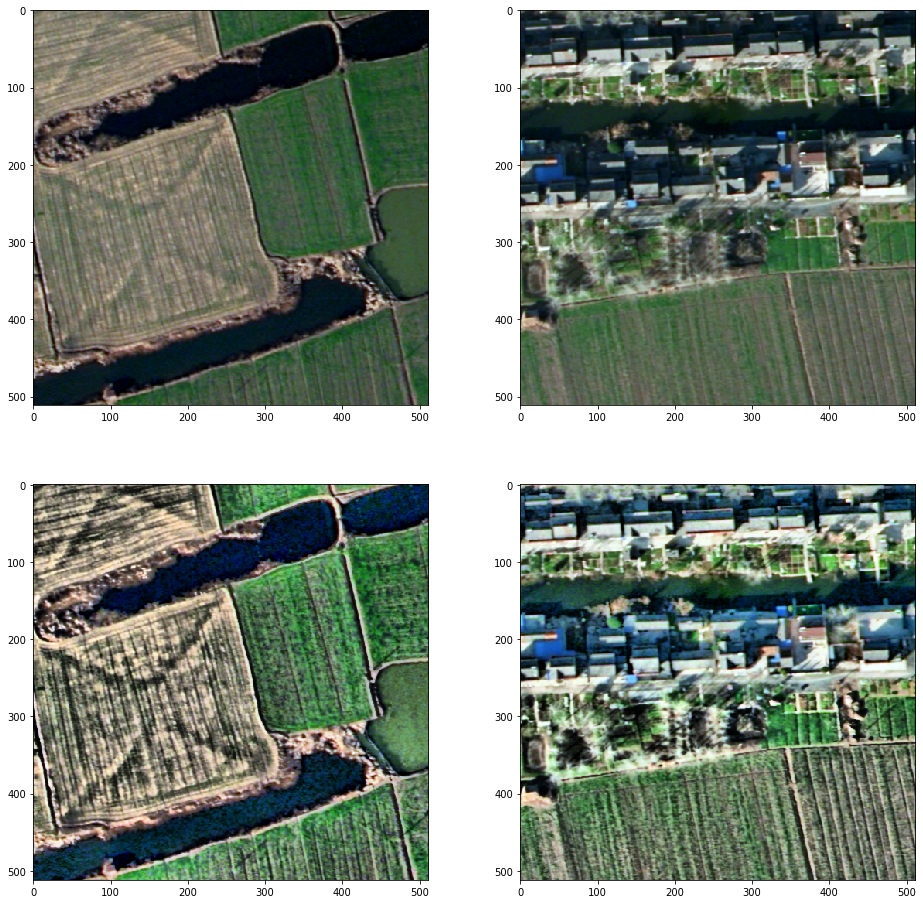

In [222]:
rootdir = './data/dataset_20200715/image/'
imgfns = ['00000.png', '00001.png']
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
for i in range(len(imgfns)):
    axs[0, i].imshow(PIL.Image.open(rootdir + imgfns[i]))
for i in range(len(imgfns)):    
    axs[1, i].imshow(databunch.imgp_CLAHE(PIL.Image.open(rootdir + imgfns[i])))

## 看一下变换对图片影响

In [341]:
#取一张图片看看内容
def getdt(ds_dir = 'data/dataset_20200715/', imgfn = '00000.png' \
          , transforms = [], show = True):
    dt = SegmentationItemList([Path(ds_dir + 'image/' + imgfn)], path = Path(ds_dir + 'image')) \
            .split_none() \
            .label_from_func(partial(databunch.get_y, ds_rootdir = ds_dir \
                                    , imgdir = 'image', maskdir = 'mask') \
                                , classes=['bg', 'water']) \
            .transform(transforms, tfm_y = True) \
            .databunch(bs = 1) \
            .normalize(imagenet_stats)
    if show:
        dt.show_batch()
    return dt
    

In [340]:
#打印各个通道的颜色值的和，大致看看图片是否有变化
def prt(dt):
    x,y = next(iter(dt.train_dl))
    n = x[0].cpu().numpy()
    print(n[0,:,:].sum(), n[1,:,:].sum(), n[2,:,:].sum())

In [ ]:
#没有transforms的原始图像
dt = getdt()
prt(dt)

In [ ]:
#因为没有设置p_affine和p_lighting导致添加的变换参数无效,只有水平翻转起作用
tfm_lighting = get_transforms(do_flip=True, flip_vert=False \
        , max_rotate=80, max_zoom=1.4, max_lighting=0.2, max_warp=0.9 \
        , p_affine=0., p_lighting=0.)
dt = getdt(transforms = tfm_lighting)
prt(dt)

In [ ]:
#因为没有设置p_affine和p_lighting导致添加的变换参数无效
#水平翻转不会改变图片的色值，但是发现垂直翻转会改变
tfm_lighting = get_transforms(do_flip=True, flip_vert=True \
        , max_rotate=80, max_zoom=1.4, max_lighting=0.2, max_warp=0.9 \
        , p_affine=0., p_lighting=0.)
dt = getdt(transforms = tfm_lighting)
prt(dt)

In [ ]:
#起作用的变换。看看效果
tfm_rotate = get_transforms(max_zoom=1., flip_vert = True, max_warp=0.)
dt = getdt(transforms = tfm_rotate)
prt(dt)

## 进行一次多批的测试看看结果是否有起伏

In [312]:
for i in range(10):
    tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'test_%d' % i])
    ds = './data/dataset_20200715'
    data_200 = databunch.get_databunch(ds, bs=BS, device=device) 
    getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)
    lrs = [1e-3]
    checkpoints = [None]
    opts = [optf_adam]

    train_script_logger.multi_train(get_learn=getlearn, 
                epoch_len=1e9, epochs=500,
                opts=opts, lrs=lrs, checkpoints=checkpoints,
                tb_log_root='./tb_log/',
                autoSave=True)
    backup_train_logs(tag)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.587069,0.788553,0.788553,0.790100,0.000000,00:23
1,0.425390,0.804361,0.804361,0.856020,0.000000,00:23
2,0.345961,0.844436,0.844436,1.055272,0.000000,00:23
3,0.303557,0.589096,0.589096,0.726901,0.303074,00:23
4,0.269460,0.296731,0.296731,0.559281,0.567899,00:23
5,0.241101,0.139759,0.139759,0.329281,0.765585,00:23
6,0.221211,0.128349,0.128349,0.384895,0.781074,00:23
7,0.202698,0.222178,0.222178,0.557676,0.651566,00:23
8,0.183678,0.113436,0.113436,0.416544,0.802112,00:23
9,0.165553,0.121842,0.121842,0.484680,0.787420,00:23


Better model found at epoch 0 with valid_loss value: 0.7885533571243286.
Better model found at epoch 3 with valid_loss value: 0.5890957117080688.
Better model found at epoch 4 with valid_loss value: 0.2967308759689331.
Better model found at epoch 5 with valid_loss value: 0.13975916802883148.
Better model found at epoch 6 with valid_loss value: 0.12834914028644562.
Better model found at epoch 8 with valid_loss value: 0.11343648284673691.
Better model found at epoch 12 with valid_loss value: 0.10747496038675308.
Better model found at epoch 14 with valid_loss value: 0.09535030275583267.
Better model found at epoch 19 with valid_loss value: 0.09051225334405899.
Better model found at epoch 22 with valid_loss value: 0.0884740948677063.
Better model found at epoch 24 with valid_loss value: 0.07854179292917252.
Better model found at epoch 25 with valid_loss value: 0.0725865364074707.
Better model found at epoch 27 with valid_loss value: 0.06862249225378036.
on end of epoch#37: start annealing 

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.595481,0.789098,0.789098,0.784814,0.000000,00:23
1,0.411406,0.798462,0.798462,0.826682,0.000000,00:23
2,0.335025,0.798220,0.798220,0.907099,0.000000,00:23
3,0.282910,0.285542,0.285542,0.308221,0.667927,00:23
4,0.250068,0.223101,0.223101,0.312861,0.655604,00:23
5,0.226354,0.351817,0.351817,1.288049,0.492978,00:23
6,0.208154,0.150032,0.150032,0.612785,0.747034,00:23
7,0.191488,0.120430,0.120430,0.495865,0.790498,00:23
8,0.175351,0.103451,0.103451,0.348326,0.816945,00:23
9,0.161298,0.118311,0.118311,0.345819,0.792986,00:23


Better model found at epoch 0 with valid_loss value: 0.7890981435775757.
Better model found at epoch 3 with valid_loss value: 0.285541832447052.
Better model found at epoch 4 with valid_loss value: 0.22310146689414978.
Better model found at epoch 6 with valid_loss value: 0.1500319540500641.
Better model found at epoch 7 with valid_loss value: 0.1204303652048111.
Better model found at epoch 8 with valid_loss value: 0.10345146805047989.
Better model found at epoch 14 with valid_loss value: 0.08790109306573868.
Better model found at epoch 15 with valid_loss value: 0.08059946447610855.
Better model found at epoch 18 with valid_loss value: 0.07856173813343048.
Better model found at epoch 26 with valid_loss value: 0.07823548465967178.
Better model found at epoch 28 with valid_loss value: 0.0689648985862732.
Better model found at epoch 31 with valid_loss value: 0.06305356323719025.
Better model found at epoch 39 with valid_loss value: 0.059773363173007965.
Better model found at epoch 40 with 

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.568590,0.813311,0.813311,0.788897,0.000000,00:23
1,0.404852,0.826984,0.826984,0.864036,0.000000,00:23
2,0.331658,0.755383,0.755383,0.813655,0.025402,00:23
3,0.280624,0.323423,0.323423,0.468091,0.647790,00:23
4,0.252329,0.168939,0.168939,0.482037,0.744660,00:23
5,0.224131,0.156990,0.156990,0.474171,0.738565,00:23
6,0.198557,0.155703,0.155703,0.731550,0.735979,00:23
7,0.179217,0.131914,0.131914,0.369214,0.773822,00:23
8,0.169964,0.146195,0.146195,0.325813,0.750148,00:23
9,0.157598,0.113843,0.113843,0.317451,0.803638,00:23


Better model found at epoch 0 with valid_loss value: 0.8133106231689453.
Better model found at epoch 2 with valid_loss value: 0.7553828954696655.
Better model found at epoch 3 with valid_loss value: 0.3234226107597351.
Better model found at epoch 4 with valid_loss value: 0.16893891990184784.
Better model found at epoch 5 with valid_loss value: 0.1569899320602417.
Better model found at epoch 6 with valid_loss value: 0.15570303797721863.
Better model found at epoch 7 with valid_loss value: 0.13191363215446472.
Better model found at epoch 9 with valid_loss value: 0.11384304612874985.
Better model found at epoch 14 with valid_loss value: 0.11289630830287933.
Better model found at epoch 17 with valid_loss value: 0.09141013771295547.
Better model found at epoch 18 with valid_loss value: 0.08391090482473373.
Better model found at epoch 19 with valid_loss value: 0.08352378755807877.
Better model found at epoch 26 with valid_loss value: 0.07949668169021606.
Better model found at epoch 27 with v

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.519814,0.775049,0.775049,0.828493,0.000000,00:23
1,0.385473,0.855213,0.855213,1.148968,0.000000,00:23
2,0.312487,0.951888,0.951888,1.815362,0.000000,00:23
3,0.269849,0.980148,0.980148,2.472110,0.001473,00:23
4,0.238473,0.201981,0.201981,0.667552,0.672993,00:23
5,0.212826,0.160841,0.160841,0.464951,0.733192,00:23
6,0.192797,0.368736,0.368736,1.588617,0.466415,00:23
7,0.177397,0.139868,0.139868,0.531811,0.761523,00:23
8,0.162978,0.121348,0.121348,0.435023,0.788370,00:23
9,0.151852,0.131340,0.131340,0.668308,0.772678,00:23


Better model found at epoch 0 with valid_loss value: 0.7750486135482788.
Better model found at epoch 4 with valid_loss value: 0.20198054611682892.
Better model found at epoch 5 with valid_loss value: 0.1608414351940155.
Better model found at epoch 7 with valid_loss value: 0.13986840844154358.
Better model found at epoch 8 with valid_loss value: 0.12134794890880585.
Better model found at epoch 10 with valid_loss value: 0.11759515106678009.
Better model found at epoch 12 with valid_loss value: 0.11108658462762833.
Better model found at epoch 15 with valid_loss value: 0.09986988455057144.
Better model found at epoch 16 with valid_loss value: 0.0997162014245987.
Better model found at epoch 19 with valid_loss value: 0.08977901935577393.
Better model found at epoch 21 with valid_loss value: 0.07677183300256729.
on end of epoch#35: start annealing from 0.001 to 0.0001
Better model found at epoch 37 with valid_loss value: 0.07558615505695343.
Better model found at epoch 38 with valid_loss valu

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.558893,0.785830,0.785830,0.798530,0.000000,00:23
1,0.399649,0.819593,0.819593,0.937239,0.000000,00:23
2,0.328420,0.880311,0.880311,1.283550,0.000000,00:23
3,0.284614,0.666020,0.666020,1.295460,0.178229,00:23
4,0.249914,0.232464,0.232464,0.756037,0.655814,00:23
5,0.232583,0.144483,0.144483,0.653618,0.758279,00:23
6,0.214976,0.133648,0.133648,0.469060,0.771069,00:23
7,0.193848,0.166318,0.166318,0.350807,0.722072,00:23
8,0.173727,0.198426,0.198426,0.958508,0.684586,00:23
9,0.157358,0.116418,0.116418,0.491105,0.801014,00:23


Better model found at epoch 0 with valid_loss value: 0.7858304381370544.
Better model found at epoch 3 with valid_loss value: 0.6660202741622925.
Better model found at epoch 4 with valid_loss value: 0.2324639856815338.
Better model found at epoch 5 with valid_loss value: 0.14448322355747223.
Better model found at epoch 6 with valid_loss value: 0.13364848494529724.
Better model found at epoch 9 with valid_loss value: 0.11641750484704971.
Better model found at epoch 11 with valid_loss value: 0.10211692750453949.
Better model found at epoch 25 with valid_loss value: 0.09583816677331924.
Better model found at epoch 26 with valid_loss value: 0.09555099159479141.
Better model found at epoch 27 with valid_loss value: 0.09418018162250519.
Better model found at epoch 29 with valid_loss value: 0.0825057402253151.
Better model found at epoch 38 with valid_loss value: 0.08068511635065079.
Better model found at epoch 40 with valid_loss value: 0.07527215778827667.
on end of epoch#47: start annealing

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.580612,0.779419,0.779419,0.802774,0.000000,00:23
1,0.410241,0.822281,0.822281,0.964643,0.000000,00:23
2,0.329395,0.907950,0.907950,1.415614,0.000000,00:23
3,0.276193,0.233145,0.233145,0.449255,0.678282,00:23
4,0.234698,0.159198,0.159198,0.381297,0.748626,00:23
5,0.205296,0.095584,0.095584,0.233309,0.852157,00:23
6,0.183498,0.341844,0.341844,1.300106,0.518054,00:23
7,0.171603,0.136473,0.136473,0.583922,0.777660,00:23
8,0.160562,0.214087,0.214087,0.540738,0.674652,00:23
9,0.150409,0.132615,0.132615,0.462109,0.774319,00:23


Better model found at epoch 0 with valid_loss value: 0.7794192433357239.
Better model found at epoch 3 with valid_loss value: 0.23314496874809265.
Better model found at epoch 4 with valid_loss value: 0.159197598695755.
Better model found at epoch 5 with valid_loss value: 0.09558431059122086.
Better model found at epoch 13 with valid_loss value: 0.08028075844049454.
Better model found at epoch 17 with valid_loss value: 0.07306307554244995.
Better model found at epoch 24 with valid_loss value: 0.07169502973556519.
Better model found at epoch 26 with valid_loss value: 0.06487134844064713.
on end of epoch#30: start annealing from 0.001 to 0.0001
Better model found at epoch 31 with valid_loss value: 0.06354012340307236.
Better model found at epoch 32 with valid_loss value: 0.061682939529418945.
Better model found at epoch 33 with valid_loss value: 0.06022101640701294.
Better model found at epoch 34 with valid_loss value: 0.059494294226169586.
Better model found at epoch 35 with valid_loss v

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.556146,0.806457,0.806457,0.802290,0.000000,00:23
1,0.396439,0.838200,0.838200,0.959525,0.000000,00:23
2,0.330194,0.915830,0.915830,1.461144,0.000000,00:23
3,0.276937,0.281396,0.281396,0.582586,0.602396,00:23
4,0.249741,0.186268,0.186268,0.531514,0.702763,00:23
5,0.224981,0.387533,0.387533,1.514758,0.457825,00:23
6,0.201815,0.149513,0.149513,0.344785,0.745180,00:23
7,0.186306,0.187348,0.187348,0.607760,0.696364,00:23
8,0.174442,0.148040,0.148040,0.351569,0.748003,00:23
9,0.160458,0.158839,0.158839,0.523492,0.731498,00:23


Better model found at epoch 0 with valid_loss value: 0.8064567446708679.
Better model found at epoch 3 with valid_loss value: 0.2813958525657654.
Better model found at epoch 4 with valid_loss value: 0.18626777827739716.
Better model found at epoch 6 with valid_loss value: 0.14951319992542267.
Better model found at epoch 8 with valid_loss value: 0.1480398029088974.
Better model found at epoch 10 with valid_loss value: 0.10210929065942764.
Better model found at epoch 15 with valid_loss value: 0.09484106302261353.
Better model found at epoch 16 with valid_loss value: 0.08805681765079498.
Better model found at epoch 25 with valid_loss value: 0.07012788206338882.
on end of epoch#46: start annealing from 0.001 to 0.0001
Better model found at epoch 58 with valid_loss value: 0.0699748545885086.
Better model found at epoch 62 with valid_loss value: 0.06894979625940323.
Better model found at epoch 63 with valid_loss value: 0.06854085624217987.
Better model found at epoch 67 with valid_loss value

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.510728,0.792279,0.792279,0.819154,0.000000,00:23
1,0.373842,0.846671,0.846671,1.062106,0.000000,00:23
2,0.312985,0.946868,0.946868,1.746993,0.000000,00:23
3,0.274079,0.712331,0.712331,1.535089,0.145450,00:23
4,0.249692,0.930148,0.930148,2.272217,0.017263,00:23
5,0.227273,0.227013,0.227013,0.905934,0.645682,00:23
6,0.207767,0.164945,0.164945,0.743721,0.722781,00:23
7,0.187369,0.131852,0.131852,0.494415,0.772941,00:23
8,0.172044,0.126972,0.126972,0.298093,0.781846,00:23
9,0.156360,0.182247,0.182247,0.847544,0.699520,00:23


Better model found at epoch 0 with valid_loss value: 0.7922786474227905.
Better model found at epoch 3 with valid_loss value: 0.7123306393623352.
Better model found at epoch 5 with valid_loss value: 0.22701263427734375.
Better model found at epoch 6 with valid_loss value: 0.1649446040391922.
Better model found at epoch 7 with valid_loss value: 0.13185246288776398.
Better model found at epoch 8 with valid_loss value: 0.12697167694568634.
Better model found at epoch 15 with valid_loss value: 0.11612135171890259.
Better model found at epoch 16 with valid_loss value: 0.09586787223815918.
Better model found at epoch 21 with valid_loss value: 0.09234394878149033.
Better model found at epoch 22 with valid_loss value: 0.09126168489456177.
Better model found at epoch 28 with valid_loss value: 0.08310383558273315.
Better model found at epoch 32 with valid_loss value: 0.08031269162893295.
Better model found at epoch 34 with valid_loss value: 0.07795830816030502.
Better model found at epoch 35 wit

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.521127,0.805382,0.805382,0.819240,0.000000,00:23
1,0.387682,0.851741,0.851741,1.050541,0.000000,00:23
2,0.309796,0.947606,0.947606,1.745121,0.000000,00:23
3,0.275539,0.984973,0.984973,2.428777,0.000000,00:23
4,0.241199,0.509291,0.509291,1.442207,0.325466,00:23
5,0.219324,0.371942,0.371942,1.048564,0.462300,00:23
6,0.199101,0.324982,0.324982,1.373134,0.519117,00:23
7,0.180018,0.195420,0.195420,0.839167,0.684715,00:23
8,0.163580,0.108081,0.108081,0.398580,0.810644,00:23
9,0.149987,0.128721,0.128721,0.350656,0.782746,00:23


Better model found at epoch 0 with valid_loss value: 0.8053817749023438.
Better model found at epoch 4 with valid_loss value: 0.5092906951904297.
Better model found at epoch 5 with valid_loss value: 0.3719421327114105.
Better model found at epoch 6 with valid_loss value: 0.32498234510421753.
Better model found at epoch 7 with valid_loss value: 0.1954200714826584.
Better model found at epoch 8 with valid_loss value: 0.10808058828115463.
Better model found at epoch 22 with valid_loss value: 0.08198343217372894.
Better model found at epoch 34 with valid_loss value: 0.07765847444534302.
Better model found at epoch 39 with valid_loss value: 0.07453005015850067.
Better model found at epoch 40 with valid_loss value: 0.07133444398641586.
Better model found at epoch 41 with valid_loss value: 0.06818680465221405.
Better model found at epoch 43 with valid_loss value: 0.0673379898071289.
on end of epoch#51: start annealing from 0.001 to 0.0001


KeyboardInterrupt: 

### 发现结果有起伏
mask_iou在0.884-0.917之间。epochs在184-393之间。  
最好的结果333个epochs，最差的结果229。  
所以波动应该在3个百分点内。

## 垂直方向的翻转变换，放到验证集上看看怎么样

In [343]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_flipHV_onvalid'])

In [354]:
tfms = get_transforms(do_flip=True, flip_vert=True
                    , max_rotate=0, max_zoom=1., max_lighting=0., max_warp=0.
                    , p_affine=0., p_lighting=0)

In [359]:
#让valid数据集也有同样的变换看看是不是有影响
tfms = (tfms[0], tfms[0])
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.05833584770610434, 'col_pct': 0.8621025263735893, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.05833584770610434, 'col_pct': 0.8621025263735893, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True, use_on_y=True)])

In [360]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200_tfm5 = databunch.get_databunch(ds, bs=BS, device=device
                , transforms = tfms) 

In [361]:
getlearn = partial(get_learn, data = data_200_tfm5, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [362]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.602412,0.759136,0.759136,0.797137,0.000000,00:29
1,0.447653,0.793428,0.793428,0.908982,0.000000,00:29
2,0.377388,0.859426,0.859426,1.197641,0.000000,00:28
3,0.332589,0.310168,0.310168,0.556818,0.580321,00:28
4,0.300844,0.186319,0.186319,0.714461,0.701559,00:29
5,0.278703,0.209242,0.209242,0.608019,0.665909,00:29
6,0.264368,0.200135,0.200135,1.030486,0.674916,00:29
7,0.252126,0.155145,0.155145,0.742393,0.738118,00:28
8,0.242981,0.165228,0.165228,0.971311,0.722866,00:28
9,0.234271,0.182321,0.182321,0.924105,0.694884,00:28


Better model found at epoch 0 with valid_loss value: 0.7591357231140137.
Better model found at epoch 3 with valid_loss value: 0.31016767024993896.
Better model found at epoch 4 with valid_loss value: 0.18631881475448608.
Better model found at epoch 7 with valid_loss value: 0.15514451265335083.
Better model found at epoch 13 with valid_loss value: 0.15238389372825623.
Better model found at epoch 14 with valid_loss value: 0.13655485212802887.
Better model found at epoch 19 with valid_loss value: 0.13470780849456787.
Better model found at epoch 24 with valid_loss value: 0.1288711428642273.
on end of epoch#36: start annealing from 0.001 to 0.0001
Better model found at epoch 38 with valid_loss value: 0.11440231651067734.
Better model found at epoch 39 with valid_loss value: 0.1129336804151535.
Better model found at epoch 40 with valid_loss value: 0.10861673206090927.
Better model found at epoch 42 with valid_loss value: 0.10815227031707764.
Better model found at epoch 44 with valid_loss val

### 结果：0.855

In [363]:
backup_train_logs(tag)

## 试一下修改平台期判断参数

In [63]:
tag = '__'.join(['resnet18', 'vanila', 'dice', 'dataset200','adam', 'NaN', 'transform_Non', 'worthN_th_10'])

In [64]:
#200数据集，带transfrom。只用flip，flip_vert也按默认的False，rotate，
ds = './data/dataset_20200715'
data_200 = databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [65]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [68]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True, worseN_th = 10)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.554587,0.777462,0.777462,0.811724,0.000000,00:32
1,0.399869,0.836797,0.836797,1.045851,0.000000,00:23
2,0.329059,0.941111,0.941111,1.692274,0.000000,00:23
3,0.291043,0.964087,0.964087,2.175390,0.001917,00:23
4,0.260063,0.135444,0.135444,0.361779,0.782758,00:23
5,0.229152,0.151448,0.151448,0.605953,0.749715,00:23
6,0.207201,0.130400,0.130400,0.564492,0.775482,00:23
7,0.188813,0.078509,0.078509,0.264634,0.862453,00:23
8,0.171522,0.106733,0.106733,0.470708,0.816669,00:24
9,0.160855,0.088601,0.088601,0.327466,0.842207,00:23


Better model found at epoch 0 with valid_loss value: 0.7774615287780762.
Better model found at epoch 4 with valid_loss value: 0.13544437289237976.
Better model found at epoch 6 with valid_loss value: 0.13040025532245636.
Better model found at epoch 7 with valid_loss value: 0.07850947231054306.
Better model found at epoch 15 with valid_loss value: 0.07219374179840088.
Better model found at epoch 16 with valid_loss value: 0.0664282813668251.
Better model found at epoch 29 with valid_loss value: 0.06633560359477997.
Better model found at epoch 31 with valid_loss value: 0.05622677877545357.
Better model found at epoch 33 with valid_loss value: 0.05614619329571724.
Better model found at epoch 34 with valid_loss value: 0.052677907049655914.
Better model found at epoch 38 with valid_loss value: 0.0520336739718914.
Better model found at epoch 44 with valid_loss value: 0.05143122747540474.
Better model found at epoch 47 with valid_loss value: 0.04859666898846626.
Better model found at epoch 48 

In [69]:
backup_train_logs(tag)

# export

In [23]:
!python ../notebook2script.py --fname 'train_eval.ipynb' --outputDir '../exp/'

Converted train_eval.ipynb to ../exp/train_eval.py
